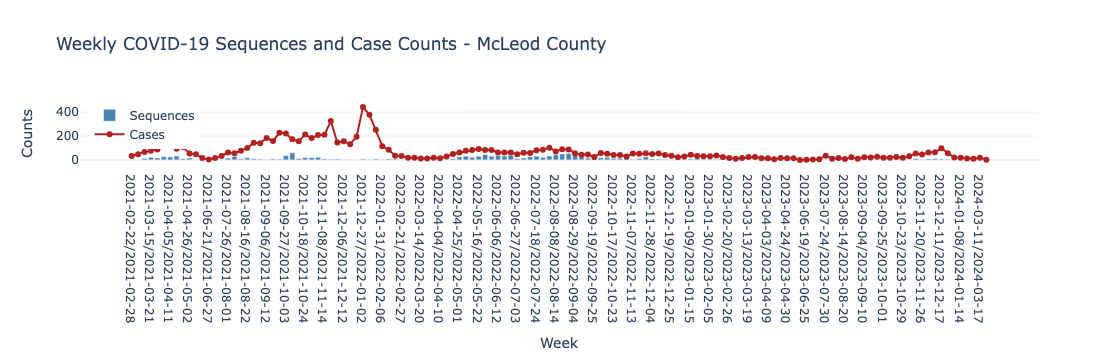

In [7]:
import pandas as pd
import plotly.graph_objects as go

# --- Load sequence metadata ---
metadata = pd.read_csv("06_17_sequences.tsv", sep="\t")
metadata['date'] = pd.to_datetime(metadata['date'], format='mixed', errors='coerce')
metadata = metadata.dropna(subset=['date'])
sequence_weekly = metadata.groupby(metadata['date'].dt.to_period("W")).size()

# --- Load case data ---
case_df = pd.read_csv("mcleod_case_counts.tsv", sep="\t")
case_df['mmwr_startdate'] = pd.to_datetime(case_df['mmwr_startdate'], format='%m/%d/%y')
case_df = case_df.set_index('mmwr_startdate')
case_weekly = case_df['case_count'].to_period("W")

# --- Combine both datasets ---
combined = pd.DataFrame({
    'Sequences': sequence_weekly,
    'Cases': case_weekly
}).dropna()

# --- Make x-axis strings for interactivity
x_labels = combined.index.astype(str)

# --- Create interactive figure ---
fig = go.Figure()

# Sequences as bars
fig.add_trace(go.Bar(
    x=x_labels,
    y=combined['Sequences'],
    name='Sequences',
    marker_color='steelblue'
))

# Cases as line
fig.add_trace(go.Scatter(
    x=x_labels,
    y=combined['Cases'],
    name='Cases',
    mode='lines+markers',
    marker=dict(color='firebrick'),
    line=dict(color='firebrick')
))

# Layout and formatting
fig.update_layout(
    title="Weekly COVID-19 Sequences and Case Counts - McLeod County",
    xaxis_title="Week",
    yaxis_title="Counts",
    hovermode="x unified",
    template="plotly_white",
    barmode="overlay",
    legend=dict(x=0.01, y=0.99)
)

# Display in notebook
fig.show()

# Optionally, save as an HTML file
fig.write_html("interactive_sequence_case_plot.html")

In [9]:
import pandas as pd
import datetime

# MMWR week conversion function for sequences
def get_mmwr_week(date):
    date = pd.to_datetime(date)
    year = date.year
    jan1 = datetime.date(year, 1, 1)
    jan1_weekday = jan1.weekday()  # Monday=0
    first_thursday = jan1 + datetime.timedelta(days=(3 - jan1_weekday) % 7)
    mmwr_week1_start = first_thursday - datetime.timedelta(days=3)
    if date.date() < mmwr_week1_start:
        year -= 1
        return get_mmwr_week(date.replace(year=year))
    delta_days = (date.date() - mmwr_week1_start).days
    week = delta_days // 7 + 1
    return f"{year}-W{week:02d}"

# Load case count data (already aggregated by MMWR week)
cases = pd.read_csv("mcleod_case_counts.tsv", sep="\t")

# Convert 'spec_date_mmwr' like '202101' to '2021-W01'
cases["spec_date_mmwr"] = cases["spec_date_mmwr"].astype(str)
cases["mmwr_week"] = cases["spec_date_mmwr"].str[:4] + "-W" + cases["spec_date_mmwr"].str[-2:]

# Use the existing case_count column as is
cases_subset = cases[["mmwr_week", "case_count"]]

# Load sequencing data with real dates
sequences = pd.read_csv("06_17_sequences.tsv", sep="\t", parse_dates=["date"])

# Assign MMWR week to each sequence
sequences["mmwr_week"] = sequences["date"].apply(get_mmwr_week)

# Count sequences per MMWR week
sequences_grouped = sequences.groupby("mmwr_week").size().reset_index(name="sequence_count")

# Merge case counts and sequence counts on MMWR week
merged = pd.merge(cases_subset, sequences_grouped, on="mmwr_week", how="outer").fillna(0)

# Convert counts to integers
merged["case_count"] = merged["case_count"].astype(int)
merged["sequence_count"] = merged["sequence_count"].astype(int)

# Calculate difference: cases minus sequences
merged["difference"] = merged["case_count"] - merged["sequence_count"]

# Sort by datetime for nice output
merged["mmwr_week_sort"] = pd.to_datetime(merged["mmwr_week"] + "-1", format="%Y-W%W-%w")
merged = merged.sort_values("mmwr_week_sort").drop(columns=["mmwr_week_sort"])

# Save results
merged.to_csv("mmwr_binned_cases_vs_sequences.csv", index=False)

# Preview the merged data
print(merged.head())

    mmwr_week  case_count  sequence_count  difference
225  2020-W01           0               1          -1
0    2021-W01          80               0          80
1    2021-W02          47               0          47
2    2021-W03          31               0          31
3    2021-W04          28               0          28


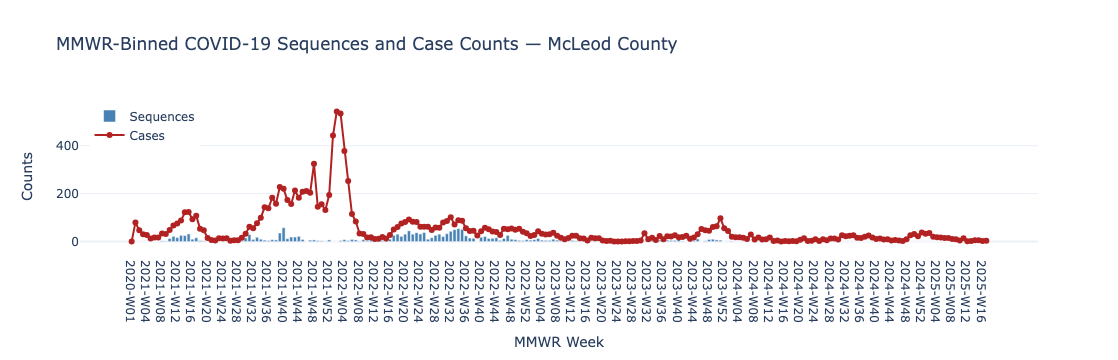

In [10]:
import pandas as pd
import plotly.graph_objects as go

# --- Load merged MMWR-binned data ---
df = pd.read_csv("mmwr_binned_cases_vs_sequences.csv")

# Optional: sort to make sure the timeline is correct
df["sort_date"] = pd.to_datetime(df["mmwr_week"] + "-1", format="%Y-W%W-%w", errors="coerce")
df = df.sort_values("sort_date")

# Prepare labels for interactivity
x_labels = df["mmwr_week"].tolist()

# --- Create interactive figure ---
fig = go.Figure()

# Sequences as bars
fig.add_trace(go.Bar(
    x=x_labels,
    y=df["sequence_count"],
    name="Sequences",
    marker_color="steelblue"
))

# Cases as line
fig.add_trace(go.Scatter(
    x=x_labels,
    y=df["case_count"],
    name="Cases",
    mode="lines+markers",
    marker=dict(color="firebrick"),
    line=dict(color="firebrick")
))

# Layout and formatting
fig.update_layout(
    title="MMWR-Binned COVID-19 Sequences and Case Counts — McLeod County",
    xaxis_title="MMWR Week",
    yaxis_title="Counts",
    hovermode="x unified",
    template="plotly_white",
    barmode="overlay",
    legend=dict(x=0.01, y=0.99)
)

# Display in notebook
fig.show()

# Optionally, save to HTML
fig.write_html("mmwr_interactive_sequence_case_plot.html")

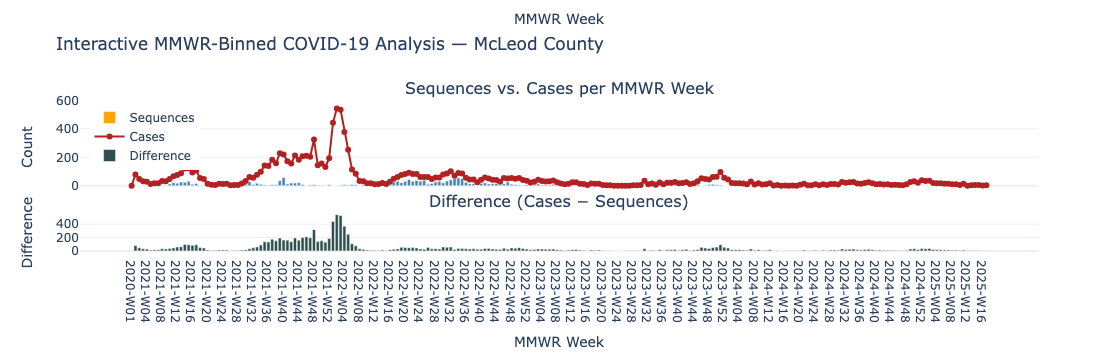

In [11]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- Load merged MMWR-binned data ---
df = pd.read_csv("mmwr_binned_cases_vs_sequences.csv")

# Parse mmwr_week to datetime for sorting
df["sort_date"] = pd.to_datetime(df["mmwr_week"] + "-1", format="%Y-W%W-%w", errors="coerce")
df = df.sort_values("sort_date")

# Prepare labels for x-axis
x_labels = df["mmwr_week"].tolist()

# --- Custom Hover Text ---
hover_text = [
    f"Week: {week}<br>Cases: {cases}<br>Sequences: {seq}<br>Difference: {diff}"
    for week, cases, seq, diff in zip(df["mmwr_week"], df["case_count"], df["sequence_count"], df["difference"])
]

# --- Bar Color by Discrepancy ---
bar_colors = ["orange" if diff < 0 else "steelblue" for diff in df["difference"]]

# --- Create Dual Subplots ---
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.12,
    row_heights=[0.7, 0.3],
    subplot_titles=("Sequences vs. Cases per MMWR Week", "Difference (Cases − Sequences)")
)

# --- Top plot: Sequences as colored bars ---
fig.add_trace(go.Bar(
    x=x_labels,
    y=df["sequence_count"],
    name="Sequences",
    marker_color=bar_colors,
    hovertext=hover_text,
    hoverinfo="text"
), row=1, col=1)

# --- Top plot: Cases as red line ---
fig.add_trace(go.Scatter(
    x=x_labels,
    y=df["case_count"],
    name="Cases",
    mode="lines+markers",
    marker=dict(color="firebrick"),
    line=dict(color="firebrick"),
    hovertext=hover_text,
    hoverinfo="text"
), row=1, col=1)

# --- Bottom plot: Difference bar chart ---
fig.add_trace(go.Bar(
    x=x_labels,
    y=df["difference"],
    name="Difference",
    marker_color="darkslategray",
    hovertext=hover_text,
    hoverinfo="text"
), row=2, col=1)

# --- Layout customization ---
fig.update_layout(
    title="Interactive MMWR-Binned COVID-19 Analysis — McLeod County",
    xaxis_title="MMWR Week",
    yaxis_title="Count",
    xaxis2_title="MMWR Week",
    yaxis2_title="Difference",
    template="plotly_white",
    hovermode="x unified",
    height=700,
    showlegend=True,
    legend=dict(x=0.01, y=0.98)
)

# Display in notebook
fig.show()

# Save to interactive HTML
fig.write_html("mmwr_dashboard_interactive.html")